# Guided mode expansion and polarization mixing

This example is related to Sec. 4.2 of the CPC paper. We calculate the bands of a PhC slab in the presence of vertical mirror symmetry and we wish to answer the following question: if a quasi-guided PhC slab mode is even (odd) under reflection in a vertical mirror plane, does it couple only to p-polarized (s-polarized) radiation modes in the far field?

We answer this question by decomposing the imaginary part of the frequency into the contributions arising from s-polarized or p-polarized plane waves. This feature is new to Legume 1.0 (2024 version, CPC paper).

In [1]:
import legume
print(f"Version of the imported legume : {legume.__version__}")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpc

import copy

Version of the imported legume : 1.0.1


## Define the PhC

We adopt the parameters of Fig. 8 of the CPC paper, but we employ dimensionless unit.

In [2]:
D = 0.2 # slab thickness in units of a
r = 0.25  # hole radius in units of a
eps_c = 1          # permittivity of circular holes
eps_b = 3.45**2    # background permittivity of slab
eps_lower, eps_upper = 1, 1  # permittivities of lower and upper claddings


lattice = legume.Lattice('square')
phc = legume.PhotCryst(lattice, eps_l=eps_lower, eps_u=eps_upper)
phc.add_layer(d=D, eps_b=eps_b)
phc.layers[-1].add_shape(legume.Circle(eps=eps_c, r=r, x_cent=0., y_cent=0))

gme = legume.GuidedModeExp(phc, gmax=4.5, truncate_g='abs')
npw = np.shape(gme.gvec)[1]  # number of plane waves in the expansion
print(f'Number of reciprocal lattice vectors in the expansion: npw = {npw}')

Number of reciprocal lattice vectors in the expansion: npw = 69


## Calculate $s-$ and $p-$ farfield coupling

For simplicity, we consider only $xy$-even modes, adopting a basis of guided modes $\alpha=0,3$.

In [3]:
nk1, nk2 = 20, 30
path = lattice.bz_path(['X', 'G', 'M'], [nk1, nk2])
gmode_inds, numeig = [0, 3], 30
verbose, compute_im = True, True
nkappa = path['kpoints'].shape[1]

gme = legume.GuidedModeExp(phc, gmax=4, truncate_g='abs')
gme.run(kpoints=path['kpoints'], angles=path['angles'], gmode_inds=gmode_inds, kz_symmetry='even',
        numeig=numeig, verbose=verbose, compute_im=compute_im)
freqs = gme.freqs
freqs_im = gme.freqs_im
freqs_im_s = gme.freqs_im*gme.unbalance_sp
freqs_im_p = gme.freqs_im*(1-gme.unbalance_sp)

Plane waves used in the expansion = 49.
1.705s total time for real part of frequencies, of which
  1.324s (78%) for guided modes computation using the gmode_compute='exact' method
  0.001s (0%) for inverse matrix of Fourier-space permittivity
  0.023s (1%) for matrix diagionalization using the 'eigh' solver
  0.199s (12%) for creating GME matrix
  0.133s (8%) for creating change of basis matrix and multiply it using dense matrices
5.440s for imaginary part computation


Prepares the light lines for the plot

In [4]:
eps_clad = [gme.phc.claddings[0].eps_avg, gme.phc.claddings[-1].eps_avg]

# this is the usual light line for the cladding
light = np.sqrt(
        np.square(gme.kpoints[0, :]) +
        np.square(gme.kpoints[1, :])) / 2 / np.pi / np.sqrt(max(eps_clad))

# this are light lines folded with various reciprocal lattice vectors
Grec1  = [0, -2*np.pi]  # this in particular gives the cutoff for out-of-plane diffraction
light1 = np.sqrt(
         np.square(gme.kpoints[0, :]+Grec1[0]) +
         np.square(gme.kpoints[1, :]+Grec1[1])) / 2 / np.pi / np.sqrt(max(eps_clad))

Grec2  = [-2*np.pi, 0]
light2 = np.sqrt(
         np.square(gme.kpoints[0, :]+Grec2[0]) +
         np.square(gme.kpoints[1, :]+Grec2[1])) / 2 / np.pi / np.sqrt(max(eps_clad))

Grec3  = [-2*np.pi, -2*np.pi]
light3 = np.sqrt(
         np.square(gme.kpoints[0, :]+Grec3[0]) +
         np.square(gme.kpoints[1, :]+Grec3[1])) / 2 / np.pi / np.sqrt(max(eps_clad))

Plot the results

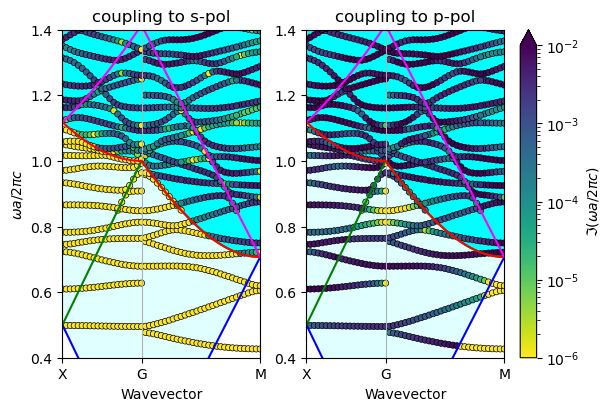

In [5]:
nfreqs = freqs.shape[1]
ymin, ymax = 0.4, 1.4

markersize = 20
vmin, vmax = 1e-6, 1e-2
conecolor ='lightcyan'
conecolor1='cyan'

# we set a minimum value to the colorscale, otherwise the points below the line line do not appear
freqs_im_s_for_plot = copy.deepcopy(freqs_im_s)
freqs_im_p_for_plot = copy.deepcopy(freqs_im_p)
for i in range(nkappa):
  for j in range(nfreqs):
    freqs_im_s_for_plot[i,j] = max(freqs_im_s[i,j], vmin)
    freqs_im_p_for_plot[i,j] = max(freqs_im_p[i,j], vmin)


fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(6, 4))
kappa = range(nkappa)
for j in range(nfreqs):
#  ax.scatter(kappa, freqs_even[:,j], c='red', s=markersize)
  f0 = ax[0].scatter(kappa, freqs[:,j], c=freqs_im_s_for_plot[:,j],
             s=markersize, edgecolors='black', linewidths=0.5,
             norm=mpc.LogNorm(vmin= vmin, vmax=vmax), cmap='viridis_r')
  f1 = ax[1].scatter(kappa, freqs[:,j], c=freqs_im_p_for_plot[:,j],
             s=markersize, edgecolors='black', linewidths=0.5,
             norm=mpc.LogNorm(vmin= vmin, vmax=vmax), cmap='viridis_r')

for a in ax: # Loop over all axis for common set-up (limits, lightcones,...)
  a.set_ylim([ymin, ymax])
  a.set_xlim([0, nkappa-1])
  a.set_xlabel("Wavevector")
  a.set_xticks(path['indexes'], path['labels'])
  a.xaxis.grid('True')
  a.plot(kappa, light,  color='blue')
  a.plot(kappa, light2, color='green')
  a.plot(kappa, light1, color='red')
  a.plot(kappa, light3, color='magenta')
  a.fill_between(kappa, light,  max(100, light.max(), gme.freqs[:].max()),
                facecolor=conecolor,        zorder=0)
  a.fill_between(kappa, light1,  max(100, light.max(), gme.freqs[:].max()),
                facecolor=conecolor1,       zorder=0)

ax[0].set_title('coupling to s-pol')
ax[0].set_ylabel("$\omega a/2\pi c$")
ax[1].set_title('coupling to p-pol')

plt.colorbar(f1, ax=ax[1], label="$\Im(\omega a/2\pi c)$", extend="max")


Interpretation:
* the blue line (light line in the cladding) determines the onset of losses of quasi-guided modes. Above this cutoff, kz-even modes start to couple to p-polarized plane waves, thus they become radiative - but there is no polarization mixing.
* the red line (folded line corresponding to the reciprocal lattice vector [0, -2*np.pi]) is the cutoff for diffraction in directions out of the ${\bf k}z$ plane. Above this cutoff, kz-even modes start to couple to s-polarized plane waves - and there is polarization mixing!

Compare with Fig. 10(a,b) of the CPC paper.